In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq
from scipy.signal import windows
from scipy.fft import fftshift

In [2]:
def load_radar_file(filepath, num_frames, num_chirp, samples_per_chirp):
    """
    Load raw radar files for processing (Note: this function is only needed when processing raw radar data into an image)

    Returns: 
        Loaded complex-valued radar (adc) files for the specified radar type
    """
    # WORKS ONLY FOR NUM_RX = 4
    num_rx = 4

    fid = open(f'{filepath}', 'rb')

    adcData = np.fromfile(fid, dtype='<i2')
    adcData = np.reshape(adcData, (int(adcData.shape[0] / (num_rx * 2)), num_rx * 2))
    adcData = adcData[:, [0, 1, 2, 3]] + 1j * adcData[:, [4, 5, 6, 7]]

    adcData = adcData.reshape(num_frames, num_chirp, samples_per_chirp, num_rx)

    return adcData

In [3]:
c = 3e8                         # speed of light in m/s

# frame config
NUM_FRAMES = 1000
NUM_CHIRP = 1                   # chirp loop count
PERIODICITY = 3                 # periodicity in ms

# profile config
FREQUENCY = 77                  # start frequency
SAMPLES_PER_CHIRP = 512         # ADC number of samples
SAMPLE_RATE_KHZ = 10000         # digout sample rate in kHz
RAMP_END_TIME_US = 60           # us
ADC_START_TIME_US = 6           # us
FREQ_SLOPE_MHZ = 60.012         # frequency slope in MHz (/us)

# chan & adc config
NUMRX = 4

SAMPLE_RATE = SAMPLE_RATE_KHZ * 1e3             # digout sample rate in Hz
SWEEP_TIME = SAMPLES_PER_CHIRP / SAMPLE_RATE
FREQ_SLOPE = FREQ_SLOPE_MHZ * 1e12              # frequency slope in Hz (/s)

BANDWIDTH = FREQ_SLOPE * SWEEP_TIME             # bandwidth in Hz
RESOLUTION = c / (2 * BANDWIDTH)                # range resolution in m

print(f"Start frequency: {FREQUENCY} Hz")
print(f"Bandwidth: {BANDWIDTH} Hz")
print(f"Sweep time: {SWEEP_TIME} s")
print(f"Slope: {FREQ_SLOPE} Hz/s")
print(f"Range resolution: {RESOLUTION} m")
print(f"Sample rate: {SAMPLE_RATE} Hz")

Start frequency: 77 Hz
Bandwidth: 3072614400.0 Hz
Sweep time: 5.12e-05 s
Slope: 60012000000000.0 Hz/s
Range resolution: 0.048818361327734455 m
Sample rate: 10000000.0 Hz


In [18]:
adc_data0 = load_radar_file('./data/adc_data_floor1m+obj_v1.bin', NUM_FRAMES, NUM_CHIRP, SAMPLES_PER_CHIRP)
print("ADC Data 0 shape:", adc_data0.shape)

adc_data1 = load_radar_file('./data/adc_data_floor1m_v1.bin', NUM_FRAMES, NUM_CHIRP, SAMPLES_PER_CHIRP)
print("ADC Data 1 shape:", adc_data1.shape)

ADC Data 0 shape: (1000, 1, 512, 4)
ADC Data 1 shape: (1000, 1, 512, 4)


In [16]:
# select only the first frame (averaged over)
adc_data1 = adc_data1[:3, :, :, :]
adc_data0 = adc_data0[:3, :, :, :]
adc_data1.shape

(1, 1, 512, 4)

Processing ADC data with shape: (1, 1, 512, 4)
Averaged data shape: (512,)
Processing ADC data with shape: (1, 1, 512, 4)
Averaged data shape: (512,)


(0.0, 2.0)

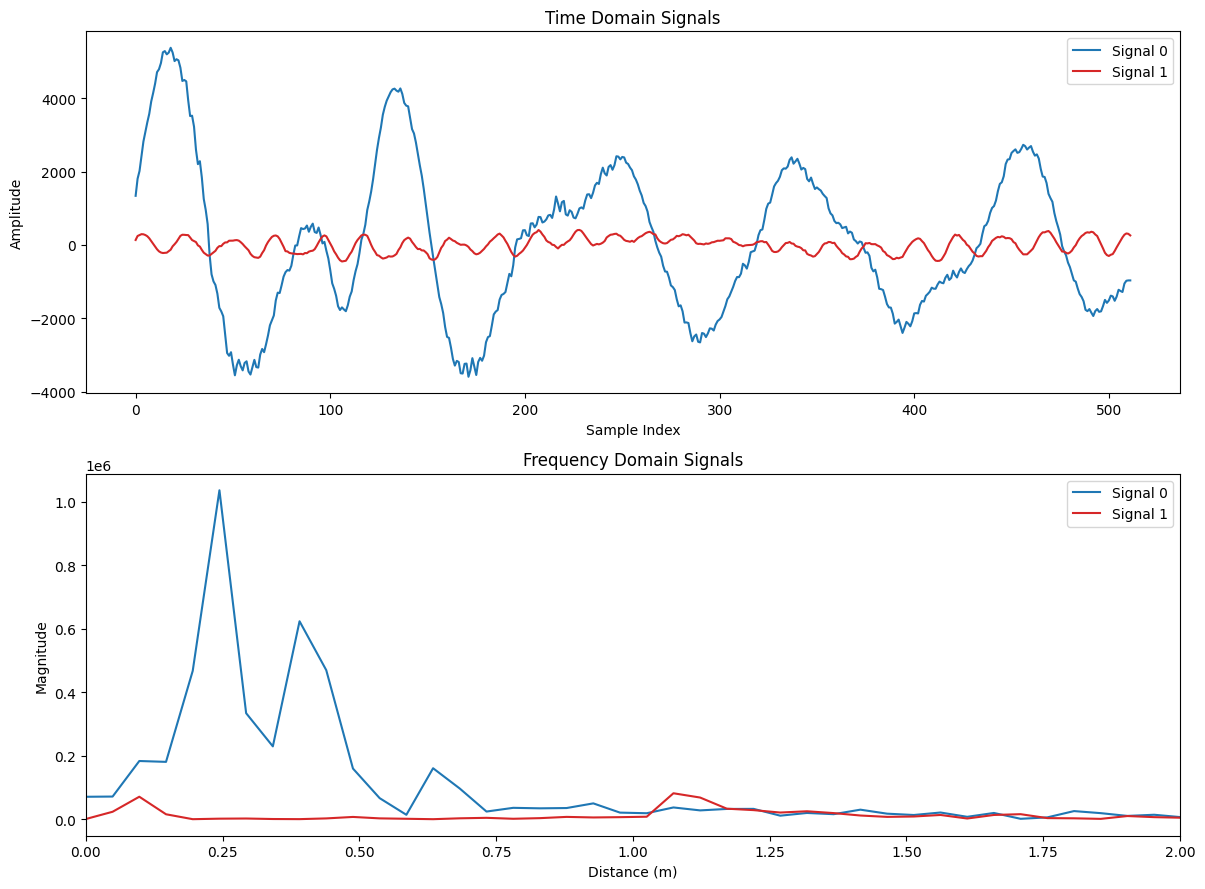

In [17]:
signals_t = []
signals_f = []

for adc_data in [adc_data0, adc_data1]:
    print("Processing ADC data with shape:", adc_data.shape)    # shape: (num_frames, num_chirp, samples_per_chirp, num_rx)

    # Average across chirps dimension
    avg_chirps = np.mean(adc_data, axis=1)                      # shape: (num_frames, samples_per_chirp, num_rx)
    avg_frames = np.mean(avg_chirps, axis=0)                    # shape: (samples_per_chirp, num_rx)
    # avg_rx = np.mean(avg_frames, axis=1)                        # shape: (samples_per_chirp,)

    data = avg_frames[:,0]
    print("Averaged data shape:", data.shape)                # shape: (samples_per_chirp, num_rx)

    # Calculate FFT
    fft_result = fft(data, axis=0)

    signals_t.append(data)
    signals_f.append(fft_result)

# Plot the signals for all signals
fft_freqs = fftfreq(SAMPLES_PER_CHIRP, 1/SAMPLE_RATE)
fft_meters = fft_freqs * c / (2 * FREQ_SLOPE)

base_colors = ['tab:blue', 'tab:red']  # Add more if you have more signals
line_styles = ['-', '--', '-.', ':']  # Up to 4 RXs, vary as needed
labels = ["Box Empty", 'Box Full']

plt.figure(figsize=(12, 9))
# --- Time Domain Plot ---
plt.subplot(2, 1, 1)
for i, signal in enumerate(signals_t):
    plt.plot(signal, label=f'Signal {i}', color=base_colors[i])
plt.title('Time Domain Signals')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()

# --- Frequency Domain Plot ---
plt.subplot(2, 1, 2)
for i, fft_result in enumerate(signals_f):
    plt.plot(fft_meters[:SAMPLES_PER_CHIRP // 2],  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2]), label=f'Signal {i}', color=base_colors[i])
plt.title('Frequency Domain Signals')
plt.xlabel('Distance (m)')
plt.ylabel('Magnitude')
plt.legend()
plt.tight_layout()

plt.xlim(0, 2)